In [4]:
import numpy as np
import torch
from brevitas.nn import QuantIdentity
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy import Node
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from aeon.datasets import load_classification

# ========== Configuration ==========
N_values = [50, 100, 200,300,400,500]
bit_widths = [4, 6, 8]
threshold_scale = 0.0078125
accuracies = {}  # {N: {bit_width: acc}}

# ========== Load and Prepare Data ==========
X_train, y_train = load_classification('Wafer', split='train')
X_test, y_test = load_classification('Wafer', split='test')

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
y_test_labels = np.argmax(y_test_cat, axis=1)

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[2])
X_full = np.append(X_train_reshaped, X_test_reshaped, axis=0)

# ========== Helper Functions ==========

def extract_Qinput(input, num_bits=8):
    quant_identity = QuantIdentity(return_quant_tensor=True, bit_width=num_bits)
    float_input = torch.tensor(input, dtype=torch.float32)
    quant_input = quant_identity(float_input)
    out = quant_input.int().detach().numpy()
    scale = quant_input.scale.detach().numpy()
    zero_point = quant_input.zero_point.numpy()
    return out, scale, zero_point

def compute_integer_thresholds(scale):
    a, b = -1, 1
    a_scaled = np.int32(a / scale)
    b_scaled = np.int32(b / scale)
    return a_scaled, b_scaled

def piecewise_linear_hard_tanh_integer(x, a_scaled, b_scaled, bit_width):
    x = np.where(x < a_scaled, a_scaled, x)
    x = np.where(x > b_scaled, b_scaled, x)
    q_range = 2 ** bit_width
    return ((x + b_scaled) / q_range).astype(np.int32)

def make_forward_fn(N, a_scaled, b_scaled, c_scaled, d_scaled, int_Win, int_Wr, int_bias, bit_width):
    def forward(node: Node, x: np.ndarray) -> np.ndarray:
        state = node.state().astype(np.int32).reshape(1, N)
        r = state @ int_Wr.astype(np.int32)
        s = x @ int_Win.astype(np.int32).T
        s = s.reshape(1, N)
        bias_res = int_bias.reshape(1, N)
        out_r = piecewise_linear_hard_tanh_integer(s, a_scaled, b_scaled, bit_width)
        out_s = piecewise_linear_hard_tanh_integer(r, c_scaled, d_scaled, bit_width)
        return out_r + out_s + bias_res
    return forward

# ========== Main Loop ==========
for N in N_values:
    print(f"\n=== Training FP Model for N={N} ===")
    # Train floating point model
    reservoir = Reservoir(units=N, input_dim=X_train_reshaped.shape[1], sr=0.4, input_connectivity=0.8,
                          rc_connectivity=0.1, input_scaling=0.3, lr=1, seed=42)
    readout = Ridge(ridge=1e-4)
    esn_model = reservoir >> readout
    esn_model.fit(X_train_reshaped, y_train_cat)
    
    y_pred = esn_model.run(X_test_reshaped)
    y_pred_labels = np.argmax(y_pred, axis=1)
    acc_fp = np.mean(y_pred_labels == y_test_labels)
    print(f"Floating-Point Accuracy: {acc_fp*100:.2f}%")

    # Store FP accuracy
    accuracies[N] = {'FP': acc_fp}

    # Extract and quantize weights
    Win = esn_model.nodes[0].Win.todense()
    Wr = esn_model.nodes[0].W.todense()
    bias = esn_model.nodes[0].bias.todense()

    for bw in bit_widths:
        print(f"→ Quantizing at {bw} bits for N={N}")
        int_x, x_scale, _ = extract_Qinput(X_full, num_bits=bw)
        int_Win, scale_Win, _ = extract_Qinput(Win, num_bits=bw)
        int_Wr, scale_Wr, _ = extract_Qinput(Wr, num_bits=bw)
        int_bias, scale_bias, _ = extract_Qinput(bias, num_bits=bw)

        input_scale = scale_Win * x_scale
        reservoir_scale = scale_Wr * threshold_scale
        a_scaled, b_scaled = compute_integer_thresholds(input_scale)
        c_scaled, d_scaled = compute_integer_thresholds(reservoir_scale)

        forward_fn = make_forward_fn(N, a_scaled, b_scaled, c_scaled, d_scaled,
                                     int_Win, int_Wr, int_bias, bw)

        def init(node, x=None, y=None):
            node.set_input_dim(x.shape[1])
            node.set_output_dim(N)
            node.set_param("Win", int_Win)
            node.set_param("Wr", int_Wr)
            node.set_param("Bias", int_bias)

        class CustomNode(Node):
            def __init__(self):
                super().__init__(
                    forward=forward_fn,
                    initializer=init,
                    params={"Win": None, "Wr": None, "Bias": None},
                    hypers={},
                    name=f"QESN_{N}_{bw}bit"
                )

        q_node = CustomNode()
        readout_q = Ridge(ridge=1e-1)
        model_q = q_node >> readout_q

        # Train quantized model
        q_states_train = q_node.run(int_x[:len(X_train_reshaped)].astype(np.float32)) * threshold_scale
        readout_q.fit(q_states_train.astype(np.float64), y_train_cat)

        q_states_test = q_node.run(int_x[len(X_train_reshaped):].astype(np.float32)) * threshold_scale
        y_pred_q = readout_q.run(q_states_test.astype(np.float32))
        y_pred_q_labels = np.argmax(y_pred_q, axis=1)

        acc_q = np.mean(y_pred_q_labels == y_test_labels)
        print(f"Quantized INT{bw} Accuracy: {acc_q*100:.2f}%")
        accuracies[N][f'INT{bw}'] = acc_q

# ========== Summary ==========
print("\n=== Accuracy Summary ===")
header = f"{'N':>5} | {'FP':>6} | " + " | ".join([f'INT{bw:>2}' for bw in bit_widths])
print(header)
print('-' * len(header))
for N in N_values:
    line = f"{N:>5} | {accuracies[N]['FP']*100:6.2f} "
    for bw in bit_widths:
        acc = accuracies[N].get(f'INT{bw}', 0)
        line += f"| {acc*100:6.2f} "
    print(line)
    



=== Training FP Model for N=50 ===


Running Model-30: 1000it [00:00, 17387.16it/s]         
Running Model-30: 100%|██████████| 1/1 [00:00<00:00, 16.74it/s]

Fitting node Ridge-2028...



Running Model-30: 6164it [00:00, 18224.06it/s]         


Floating-Point Accuracy: 94.97%
→ Quantizing at 4 bits for N=50


Running Ridge-2029: 100%|██████████| 6164/6164 [00:00<00:00, 125729.17it/s]


Quantized INT4 Accuracy: 89.21%
→ Quantizing at 6 bits for N=50


Running Ridge-2030: 100%|██████████| 6164/6164 [00:00<00:00, 131034.13it/s]


Quantized INT6 Accuracy: 92.25%
→ Quantizing at 8 bits for N=50


Running Ridge-2031: 100%|██████████| 6164/6164 [00:00<00:00, 120472.17it/s]


Quantized INT8 Accuracy: 92.72%

=== Training FP Model for N=100 ===


Running Model-34: 1000it [00:00, 16574.61it/s]         
Running Model-34: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


Fitting node Ridge-2032...


Running Model-34: 6164it [00:00, 17149.68it/s]         


Floating-Point Accuracy: 97.23%
→ Quantizing at 4 bits for N=100


Running Ridge-2033: 100%|██████████| 6164/6164 [00:00<00:00, 58905.38it/s]


Quantized INT4 Accuracy: 89.21%
→ Quantizing at 6 bits for N=100


Running Ridge-2034: 100%|██████████| 6164/6164 [00:00<00:00, 79132.97it/s]


Quantized INT6 Accuracy: 93.12%
→ Quantizing at 8 bits for N=100


Running Ridge-2035: 100%|██████████| 6164/6164 [00:00<00:00, 74251.89it/s]


Quantized INT8 Accuracy: 93.67%

=== Training FP Model for N=200 ===


Running Model-38: 1000it [00:00, 14877.96it/s]         
Running Model-38: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


Fitting node Ridge-2036...


Running Model-38: 6164it [00:00, 13402.47it/s]         


Floating-Point Accuracy: 97.91%
→ Quantizing at 4 bits for N=200


Running Ridge-2037: 100%|██████████| 6164/6164 [00:00<00:00, 60000.39it/s]


Quantized INT4 Accuracy: 91.68%
→ Quantizing at 6 bits for N=200


Running Ridge-2038: 100%|██████████| 6164/6164 [00:00<00:00, 64790.04it/s]


Quantized INT6 Accuracy: 94.05%
→ Quantizing at 8 bits for N=200


Running Ridge-2039: 100%|██████████| 6164/6164 [00:00<00:00, 74497.29it/s]


Quantized INT8 Accuracy: 94.71%

=== Training FP Model for N=300 ===


Running Model-42: 1000it [00:00, 12131.10it/s]         
Running Model-42: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


Fitting node Ridge-2040...


Running Model-42: 6164it [00:00, 13565.31it/s]         


Floating-Point Accuracy: 98.48%
→ Quantizing at 4 bits for N=300


Running Ridge-2041: 100%|██████████| 6164/6164 [00:00<00:00, 59460.97it/s]


Quantized INT4 Accuracy: 92.42%
→ Quantizing at 6 bits for N=300


Running Ridge-2042: 100%|██████████| 6164/6164 [00:00<00:00, 58106.80it/s]


Quantized INT6 Accuracy: 94.47%
→ Quantizing at 8 bits for N=300


Running Ridge-2043: 100%|██████████| 6164/6164 [00:00<00:00, 73779.36it/s]


Quantized INT8 Accuracy: 95.18%

=== Training FP Model for N=400 ===


Running Model-46: 1000it [00:00, 12131.70it/s]         
Running Model-46: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


Fitting node Ridge-2044...


Running Model-46: 6164it [00:00, 11254.55it/s]         


Floating-Point Accuracy: 98.99%
→ Quantizing at 4 bits for N=400


Running Ridge-2045: 100%|██████████| 6164/6164 [00:00<00:00, 59101.71it/s]


Quantized INT4 Accuracy: 93.30%
→ Quantizing at 6 bits for N=400


Running Ridge-2046: 100%|██████████| 6164/6164 [00:00<00:00, 73400.23it/s]


Quantized INT6 Accuracy: 95.26%
→ Quantizing at 8 bits for N=400


Running Ridge-2047: 100%|██████████| 6164/6164 [00:00<00:00, 71975.55it/s]


Quantized INT8 Accuracy: 95.67%

=== Training FP Model for N=500 ===


Running Model-50: 1000it [00:00, 6986.97it/s]<?, ?it/s]
Running Model-50: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


Fitting node Ridge-2048...


Running Model-50: 6164it [00:00, 11082.95it/s]         


Floating-Point Accuracy: 98.33%
→ Quantizing at 4 bits for N=500


Running Ridge-2049: 100%|██████████| 6164/6164 [00:00<00:00, 73525.48it/s]


Quantized INT4 Accuracy: 93.61%
→ Quantizing at 6 bits for N=500


Running Ridge-2050: 100%|██████████| 6164/6164 [00:00<00:00, 73005.39it/s]


Quantized INT6 Accuracy: 94.81%
→ Quantizing at 8 bits for N=500


Running Ridge-2051: 100%|██████████| 6164/6164 [00:00<00:00, 59685.96it/s]

Quantized INT8 Accuracy: 95.20%

=== Accuracy Summary ===
    N |     FP | INT 4 | INT 6 | INT 8
--------------------------------------
   50 |  94.97 |  89.21 |  92.25 |  92.72 
  100 |  97.23 |  89.21 |  93.12 |  93.67 
  200 |  97.91 |  91.68 |  94.05 |  94.71 
  300 |  98.48 |  92.42 |  94.47 |  95.18 
  400 |  98.99 |  93.30 |  95.26 |  95.67 
  500 |  98.33 |  93.61 |  94.81 |  95.20 


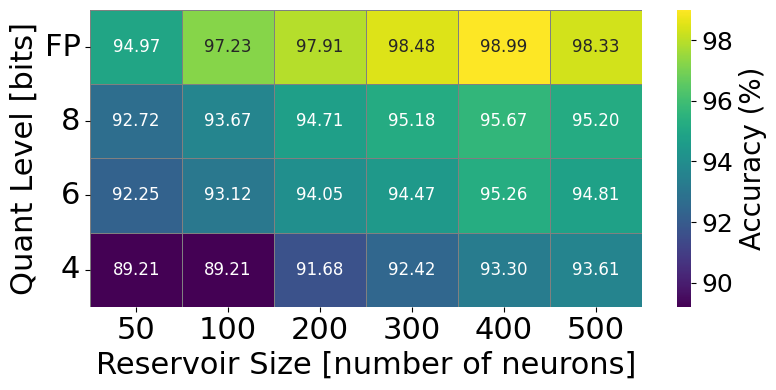

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define reversed order of quantization levels (FP on top)
quant_levels = ['FP'] + [f'INT{bw}' for bw in reversed(bit_widths)]

# Build the DataFrame: rows=Quantization Levels, columns=Reservoir Sizes
heatmap_data = {N: [accuracies[N].get(level, 0) * 100 for level in quant_levels] for N in N_values}
df = pd.DataFrame(heatmap_data, index=quant_levels)

# Ensure proper column order
df = df[[50, 100, 200, 300, 400, 500]]

# Prepare labels without "INT"
y_labels = ['FP'] + [str(bw) for bw in reversed(bit_widths)]

# Plot the heatmap
plt.figure(figsize=(8, 4))
ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis",
                 cbar_kws={'label': 'Accuracy (%)'},
                 annot_kws={"size": 12}, linewidths=0.5, linecolor='gray')

# Set axis labels and ticks
plt.xlabel('Reservoir Size [number of neurons]', fontsize=22)
plt.ylabel('Quant Level [bits]', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(ticks=[i + 0.5 for i in range(len(y_labels))], labels=y_labels, fontsize=22, rotation=0)

# Set colorbar label font size
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=18)
colorbar.set_label('Accuracy (%)', fontsize=20)

plt.tight_layout()
plt.savefig("wafer.pdf", bbox_inches='tight')
plt.show()


In [6]:
import numpy as np
import torch
from brevitas.nn import QuantIdentity
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy import Node
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, recall_score, classification_report
import matplotlib.pyplot as plt  # (unused but kept from your original)
from aeon.datasets import load_classification

# ========== Configuration ==========
N_values = [50, 100, 200, 300, 400, 500]
bit_widths = [4, 6, 8]
threshold_scale = 0.0078125

# ========== Load and Prepare Data ==========
X_train, y_train = load_classification('Wafer', split='train')
X_test, y_test = load_classification('Wafer', split='test')

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
y_test_labels = np.argmax(y_test_cat, axis=1)

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[2])
X_full = np.append(X_train_reshaped, X_test_reshaped, axis=0)

# ========== Helper Functions ==========

def extract_Qinput(input, num_bits=8):
    quant_identity = QuantIdentity(return_quant_tensor=True, bit_width=num_bits)
    float_input = torch.tensor(input, dtype=torch.float32)
    quant_input = quant_identity(float_input)
    out = quant_input.int().detach().numpy()
    scale = quant_input.scale.detach().numpy()
    zero_point = quant_input.zero_point.numpy()
    return out, scale, zero_point

def compute_integer_thresholds(scale):
    a, b = -1, 1
    a_scaled = np.int32(a / scale)
    b_scaled = np.int32(b / scale)
    return a_scaled, b_scaled

def piecewise_linear_hard_tanh_integer(x, a_scaled, b_scaled, bit_width):
    x = np.where(x < a_scaled, a_scaled, x)
    x = np.where(x > b_scaled, b_scaled, x)
    q_range = 2 ** bit_width
    return ((x + b_scaled) / q_range).astype(np.int32)

def make_forward_fn(N, a_scaled, b_scaled, c_scaled, d_scaled, int_Win, int_Wr, int_bias, bit_width):
    def forward(node: Node, x: np.ndarray) -> np.ndarray:
        state = node.state().astype(np.int32).reshape(1, N)
        r = state @ int_Wr.astype(np.int32)
        s = x @ int_Win.astype(np.int32).T
        s = s.reshape(1, N)
        bias_res = int_bias.reshape(1, N)
        out_r = piecewise_linear_hard_tanh_integer(s, a_scaled, b_scaled, bit_width)
        out_s = piecewise_linear_hard_tanh_integer(r, c_scaled, d_scaled, bit_width)
        return out_r + out_s + bias_res
    return forward

# ---- NEW: metrics helper ----
def summarize_metrics(y_true, y_pred, label=""):
    acc = (y_true == y_pred).mean()
    f1_mac = f1_score(y_true, y_pred, average="macro", zero_division=0)
    f1_wt  = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    rec_mac = recall_score(y_true, y_pred, average="macro", zero_division=0)
    rec_wt  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    print(f"{label}  Acc: {acc*100:6.2f}% | F1(macro): {f1_mac:0.4f} | Recall(macro): {rec_mac:0.4f} "
          f"| F1(weighted): {f1_wt:0.4f} | Recall(weighted): {rec_wt:0.4f}")
    return {
        "acc": acc, "f1_macro": f1_mac, "recall_macro": rec_mac,
        "f1_weighted": f1_wt, "recall_weighted": rec_wt
    }

# ===== REPLACE 'accuracies' with richer container =====
metrics_by_N = {}  # {N: {variant: metrics}}

# ========== Main Loop ==========
for N in N_values:
    print(f"\n=== Training FP Model for N={N} ===")

    # Train floating point model
    reservoir = Reservoir(
        units=N,
        input_dim=X_train_reshaped.shape[1],
        sr=0.4,
        input_connectivity=0.8,
        rc_connectivity=0.1,
        input_scaling=0.3,
        lr=1,
        seed=42
    )
    readout = Ridge(ridge=1e-4)
    esn_model = reservoir >> readout
    esn_model.fit(X_train_reshaped, y_train_cat)

    # FP predictions and metrics
    y_pred = esn_model.run(X_test_reshaped)
    y_pred_labels = np.argmax(y_pred, axis=1)
    acc_fp = np.mean(y_pred_labels == y_test_labels)
    print(f"Floating-Point Accuracy: {acc_fp*100:.2f}%")

    metrics_by_N.setdefault(N, {})
    metrics_by_N[N]['FP'] = summarize_metrics(y_test_labels, y_pred_labels, label=f"[N={N} | FP ]")

    # Extract and quantize weights
    Win = esn_model.nodes[0].Win.todense()
    Wr = esn_model.nodes[0].W.todense()
    bias = esn_model.nodes[0].bias.todense()

    for bw in bit_widths:
        print(f"→ Quantizing at {bw} bits for N={N}")
        int_x, x_scale, _ = extract_Qinput(X_full, num_bits=bw)
        int_Win, scale_Win, _ = extract_Qinput(Win, num_bits=bw)
        int_Wr, scale_Wr, _ = extract_Qinput(Wr, num_bits=bw)
        int_bias, scale_bias, _ = extract_Qinput(bias, num_bits=bw)

        input_scale = scale_Win * x_scale
        reservoir_scale = scale_Wr * threshold_scale
        a_scaled, b_scaled = compute_integer_thresholds(input_scale)
        c_scaled, d_scaled = compute_integer_thresholds(reservoir_scale)

        forward_fn = make_forward_fn(
            N, a_scaled, b_scaled, c_scaled, d_scaled,
            int_Win, int_Wr, int_bias, bw
        )

        def init(node, x=None, y=None):
            node.set_input_dim(x.shape[1])
            node.set_output_dim(N)
            node.set_param("Win", int_Win)
            node.set_param("Wr", int_Wr)
            node.set_param("Bias", int_bias)

        class CustomNode(Node):
            def __init__(self):
                super().__init__(
                    forward=forward_fn,
                    initializer=init,
                    params={"Win": None, "Wr": None, "Bias": None},
                    hypers={},
                    name=f"QESN_{N}_{bw}bit"
                )

        q_node = CustomNode()
        readout_q = Ridge(ridge=1e-1)
        model_q = q_node >> readout_q

        # Train quantized model
        q_states_train = q_node.run(int_x[:len(X_train_reshaped)].astype(np.float32)) * threshold_scale
        readout_q.fit(q_states_train.astype(np.float64), y_train_cat)

        # Test quantized model
        q_states_test = q_node.run(int_x[len(X_train_reshaped):].astype(np.float32)) * threshold_scale
        y_pred_q = readout_q.run(q_states_test.astype(np.float32))
        y_pred_q_labels = np.argmax(y_pred_q, axis=1)

        acc_q = np.mean(y_pred_q_labels == y_test_labels)
        print(f"Quantized INT{bw} Accuracy: {acc_q*100:.2f}%")

        metrics_by_N[N][f'INT{bw}'] = summarize_metrics(
            y_test_labels, y_pred_q_labels, label=f"[N={N} | INT{bw}]"
        )

# ========== Summaries ==========
print("\n=== Macro/Weighted F1 & Recall Summary ===")
header = (
    f"{'N':>5} | {'Variant':>8} | {'Acc%':>7} | "
    f"{'F1(macro)':>9} | {'Recall(macro)':>12} | "
    f"{'F1(weighted)':>12} | {'Recall(weighted)':>15}"
)
print(header)
print('-' * len(header))
for N in N_values:
    for variant, m in metrics_by_N.get(N, {}).items():
        print(
            f"{N:>5} | {variant:>8} | {m['acc']*100:7.2f} | "
            f"{m['f1_macro']:9.4f} | {m['recall_macro']:12.4f} | "
            f"{m['f1_weighted']:12.4f} | {m['recall_weighted']:15.4f}"
        )

# ===== OPTIONAL: per-class report for the last evaluated model =====
# print("\n=== Per-class report for the last model evaluated ===")
# print(classification_report(y_test_labels, y_pred_q_labels, digits=4))



=== Training FP Model for N=50 ===


Running Model-54: 1000it [00:00, 15011.40it/s]         
Running Model-54: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]

Fitting node Ridge-2052...



Running Model-54: 6164it [00:00, 16573.24it/s]         


Floating-Point Accuracy: 94.97%
[N=50 | FP ]  Acc:  94.97% | F1(macro): 0.8567 | Recall(macro): 0.8257 | F1(weighted): 0.9472 | Recall(weighted): 0.9497
→ Quantizing at 4 bits for N=50


Running Ridge-2053: 100%|██████████| 6164/6164 [00:00<00:00, 114809.87it/s]


Quantized INT4 Accuracy: 89.21%
[N=50 | INT4]  Acc:  89.21% | F1(macro): 0.4715 | Recall(macro): 0.5000 | F1(weighted): 0.8412 | Recall(weighted): 0.8921
→ Quantizing at 6 bits for N=50


Running Ridge-2054: 100%|██████████| 6164/6164 [00:00<00:00, 79557.65it/s]


Quantized INT6 Accuracy: 92.25%
[N=50 | INT6]  Acc:  92.25% | F1(macro): 0.7063 | Recall(macro): 0.6485 | F1(weighted): 0.9039 | Recall(weighted): 0.9225
→ Quantizing at 8 bits for N=50


Running Ridge-2055: 100%|██████████| 6164/6164 [00:00<00:00, 110177.45it/s]


Quantized INT8 Accuracy: 92.72%
[N=50 | INT8]  Acc:  92.72% | F1(macro): 0.7344 | Recall(macro): 0.6730 | F1(weighted): 0.9119 | Recall(weighted): 0.9272

=== Training FP Model for N=100 ===


Running Model-58: 1000it [00:00, 12066.09it/s]         
Running Model-58: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


Fitting node Ridge-2056...


Running Model-58: 6164it [00:00, 13246.99it/s]         


Floating-Point Accuracy: 97.23%
[N=100 | FP ]  Acc:  97.23% | F1(macro): 0.9265 | Recall(macro): 0.9184 | F1(weighted): 0.9720 | Recall(weighted): 0.9723
→ Quantizing at 4 bits for N=100


Running Ridge-2057: 100%|██████████| 6164/6164 [00:00<00:00, 43546.43it/s]


Quantized INT4 Accuracy: 89.21%
[N=100 | INT4]  Acc:  89.21% | F1(macro): 0.4715 | Recall(macro): 0.5000 | F1(weighted): 0.8412 | Recall(weighted): 0.8921
→ Quantizing at 6 bits for N=100


Running Ridge-2058: 100%|██████████| 6164/6164 [00:00<00:00, 62441.29it/s]


Quantized INT6 Accuracy: 93.12%
[N=100 | INT6]  Acc:  93.12% | F1(macro): 0.7641 | Recall(macro): 0.7043 | F1(weighted): 0.9198 | Recall(weighted): 0.9312
→ Quantizing at 8 bits for N=100


Running Ridge-2059: 100%|██████████| 6164/6164 [00:00<00:00, 75738.65it/s]


Quantized INT8 Accuracy: 93.67%
[N=100 | INT8]  Acc:  93.67% | F1(macro): 0.7959 | Recall(macro): 0.7411 | F1(weighted): 0.9289 | Recall(weighted): 0.9367

=== Training FP Model for N=200 ===


Running Model-62: 1000it [00:00, 13923.51it/s]         
Running Model-62: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


Fitting node Ridge-2060...


Running Model-62: 6164it [00:00, 13840.07it/s]         


Floating-Point Accuracy: 97.91%
[N=200 | FP ]  Acc:  97.91% | F1(macro): 0.9454 | Recall(macro): 0.9433 | F1(weighted): 0.9790 | Recall(weighted): 0.9791
→ Quantizing at 4 bits for N=200


Running Ridge-2061: 100%|██████████| 6164/6164 [00:00<00:00, 58264.07it/s]


Quantized INT4 Accuracy: 91.68%
[N=200 | INT4]  Acc:  91.68% | F1(macro): 0.6638 | Recall(macro): 0.6143 | F1(weighted): 0.8925 | Recall(weighted): 0.9168
→ Quantizing at 6 bits for N=200


Running Ridge-2062: 100%|██████████| 6164/6164 [00:00<00:00, 61006.47it/s]


Quantized INT6 Accuracy: 94.05%
[N=200 | INT6]  Acc:  94.05% | F1(macro): 0.8037 | Recall(macro): 0.7426 | F1(weighted): 0.9322 | Recall(weighted): 0.9405
→ Quantizing at 8 bits for N=200


Running Ridge-2063: 100%|██████████| 6164/6164 [00:00<00:00, 75019.77it/s]


Quantized INT8 Accuracy: 94.71%
[N=200 | INT8]  Acc:  94.71% | F1(macro): 0.8378 | Recall(macro): 0.7879 | F1(weighted): 0.9422 | Recall(weighted): 0.9471

=== Training FP Model for N=300 ===


Running Model-66: 1000it [00:00, 13377.72it/s]         
Running Model-66: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


Fitting node Ridge-2064...


Running Model-66: 6164it [00:00, 14030.57it/s]         


Floating-Point Accuracy: 98.48%
[N=300 | FP ]  Acc:  98.48% | F1(macro): 0.9603 | Recall(macro): 0.9591 | F1(weighted): 0.9847 | Recall(weighted): 0.9848
→ Quantizing at 4 bits for N=300


Running Ridge-2065: 100%|██████████| 6164/6164 [00:00<00:00, 67154.53it/s]


Quantized INT4 Accuracy: 92.42%
[N=300 | INT4]  Acc:  92.42% | F1(macro): 0.7115 | Recall(macro): 0.6515 | F1(weighted): 0.9058 | Recall(weighted): 0.9242
→ Quantizing at 6 bits for N=300


Running Ridge-2066: 100%|██████████| 6164/6164 [00:00<00:00, 71310.29it/s]


Quantized INT6 Accuracy: 94.47%
[N=300 | INT6]  Acc:  94.47% | F1(macro): 0.8239 | Recall(macro): 0.7667 | F1(weighted): 0.9383 | Recall(weighted): 0.9447
→ Quantizing at 8 bits for N=300


Running Ridge-2067: 100%|██████████| 6164/6164 [00:00<00:00, 69545.53it/s]


Quantized INT8 Accuracy: 95.18%
[N=300 | INT8]  Acc:  95.18% | F1(macro): 0.8566 | Recall(macro): 0.8124 | F1(weighted): 0.9482 | Recall(weighted): 0.9518

=== Training FP Model for N=400 ===


Running Model-70: 1000it [00:00, 12029.89it/s]         
Running Model-70: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


Fitting node Ridge-2068...


Running Model-70: 6164it [00:00, 11470.55it/s]         


Floating-Point Accuracy: 98.99%
[N=400 | FP ]  Acc:  98.99% | F1(macro): 0.9735 | Recall(macro): 0.9673 | F1(weighted): 0.9899 | Recall(weighted): 0.9899
→ Quantizing at 4 bits for N=400


Running Ridge-2069: 100%|██████████| 6164/6164 [00:00<00:00, 68257.68it/s]


Quantized INT4 Accuracy: 93.30%
[N=400 | INT4]  Acc:  93.30% | F1(macro): 0.7572 | Recall(macro): 0.6901 | F1(weighted): 0.9192 | Recall(weighted): 0.9330
→ Quantizing at 6 bits for N=400


Running Ridge-2070: 100%|██████████| 6164/6164 [00:00<00:00, 69324.92it/s]


Quantized INT6 Accuracy: 95.26%
[N=400 | INT6]  Acc:  95.26% | F1(macro): 0.8518 | Recall(macro): 0.7943 | F1(weighted): 0.9477 | Recall(weighted): 0.9526
→ Quantizing at 8 bits for N=400


Running Ridge-2071: 100%|██████████| 6164/6164 [00:00<00:00, 69553.01it/s]


Quantized INT8 Accuracy: 95.67%
[N=400 | INT8]  Acc:  95.67% | F1(macro): 0.8734 | Recall(macro): 0.8330 | F1(weighted): 0.9539 | Recall(weighted): 0.9567

=== Training FP Model for N=500 ===


Running Model-74: 1000it [00:00, 8315.17it/s]<?, ?it/s]
Running Model-74: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


Fitting node Ridge-2072...


Running Model-74: 6164it [00:00, 10692.05it/s]         


Floating-Point Accuracy: 98.33%
[N=500 | FP ]  Acc:  98.33% | F1(macro): 0.9567 | Recall(macro): 0.9576 | F1(weighted): 0.9833 | Recall(weighted): 0.9833
→ Quantizing at 4 bits for N=500


Running Ridge-2073: 100%|██████████| 6164/6164 [00:00<00:00, 53642.48it/s]


Quantized INT4 Accuracy: 93.61%
[N=500 | INT4]  Acc:  93.61% | F1(macro): 0.7736 | Recall(macro): 0.7057 | F1(weighted): 0.9240 | Recall(weighted): 0.9361
→ Quantizing at 6 bits for N=500


Running Ridge-2074: 100%|██████████| 6164/6164 [00:00<00:00, 72216.61it/s]


Quantized INT6 Accuracy: 94.81%
[N=500 | INT6]  Acc:  94.81% | F1(macro): 0.8360 | Recall(macro): 0.7786 | F1(weighted): 0.9423 | Recall(weighted): 0.9481
→ Quantizing at 8 bits for N=500


Running Ridge-2075: 100%|██████████| 6164/6164 [00:00<00:00, 69206.53it/s]

Quantized INT8 Accuracy: 95.20%
[N=500 | INT8]  Acc:  95.20% | F1(macro): 0.8589 | Recall(macro): 0.8184 | F1(weighted): 0.9488 | Recall(weighted): 0.9520

=== Macro/Weighted F1 & Recall Summary ===
    N |  Variant |    Acc% | F1(macro) | Recall(macro) | F1(weighted) | Recall(weighted)
----------------------------------------------------------------------------------------
   50 |       FP |   94.97 |    0.8567 |       0.8257 |       0.9472 |          0.9497
   50 |     INT4 |   89.21 |    0.4715 |       0.5000 |       0.8412 |          0.8921
   50 |     INT6 |   92.25 |    0.7063 |       0.6485 |       0.9039 |          0.9225
   50 |     INT8 |   92.72 |    0.7344 |       0.6730 |       0.9119 |          0.9272
  100 |       FP |   97.23 |    0.9265 |       0.9184 |       0.9720 |          0.9723
  100 |     INT4 |   89.21 |    0.4715 |       0.5000 |       0.8412 |          0.8921
  100 |     INT6 |   93.12 |    0.7641 |       0.7043 |       0.9198 |          0.9312
  100 |     IN